
# Data Upload




In [ ]:
!pip install cvxopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install opendatasets
!pip install pandas
!pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 993 kB 6.1 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=5d6acc3cf62129c54ad042b1aa062ef4d946ff84a7a4f757bed5361f0c6be9ec
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


In [ ]:
from cvxopt import matrix, solvers
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import skfuzzy as fuzzy


In [ ]:
od.download("https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chrismontasser
Your Kaggle Key: ··········


100%|██████████| 1.64M/1.64M [00:00<00:00, 33.9MB/s]

In [ ]:
df = pd.read_csv("/content/smoke-detection-dataset/smoke_detection_iot.csv")
df.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


# Data Preprocessing 

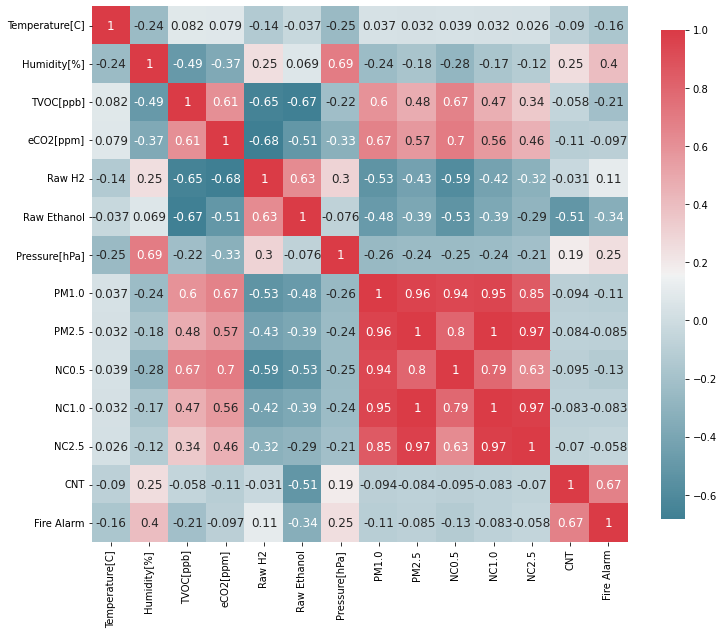

In [ ]:
def plot_correlation_map(df ):
    corr = df.corr()
    s , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    s = sns.heatmap(
            corr, 
            cmap = cmap,
            square=True, 
            cbar_kws={ 'shrink' : .9 }, 
            ax=ax, 
            annot = True, 
            annot_kws = { 'fontsize' : 12 }
            )
plot_correlation_map( df )

In [ ]:
y = df.pop('Fire Alarm').to_numpy()
X = df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [ ]:
df.drop(['Unnamed: 0', 'UTC'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature[C]  62630 non-null  float64
 1   Humidity[%]     62630 non-null  float64
 2   TVOC[ppb]       62630 non-null  int64  
 3   eCO2[ppm]       62630 non-null  int64  
 4   Raw H2          62630 non-null  int64  
 5   Raw Ethanol     62630 non-null  int64  
 6   Pressure[hPa]   62630 non-null  float64
 7   PM1.0           62630 non-null  float64
 8   PM2.5           62630 non-null  float64
 9   NC0.5           62630 non-null  float64
 10  NC1.0           62630 non-null  float64
 11  NC2.5           62630 non-null  float64
 12  CNT             62630 non-null  int64  
 13  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(6)
memory usage: 6.7 MB


In [ ]:
# class count
class_count_1, class_count_0 = df['Fire Alarm'].value_counts()

# Separate class
class_0 = df[df['Fire Alarm'] == 0]
class_1 = df[df['Fire Alarm'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (17873, 14)
class 1: (44757, 14)


total class of 1 and0: 1    17873
0    17873
Name: Fire Alarm, dtype: int64


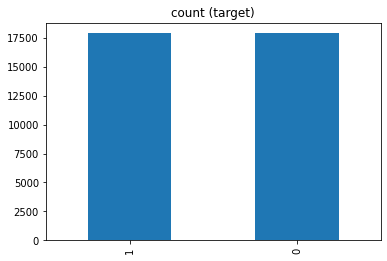

In [ ]:
class_1_under = class_1.sample(class_count_0)

test_under = pd.concat([class_1_under, class_0], axis=0)

print("total class of 1 and0:",test_under['Fire Alarm'].value_counts())# plot the count after under-sampeling
test_under['Fire Alarm'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
df = pd.concat([class_1_under, class_0 ])

 # Model Fuzzy cMean

In [ ]:
cntr, u_orig, _, _, _, _, _ = fuzzy.cluster.cmeans(data= X_train.T, c=2, m =2, error=0.005, maxiter=1000)

In [ ]:
np.shape(u_orig)

(2, 25022)

In [ ]:
cluster_membership_cut = fuzzy.defuzzify.lambda_cut(u_orig, 0.9)
cluster_membership_cut

array([[0, 1, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 0]])

In [ ]:
cluster_membership_cut_2 = np.argmax(cluster_membership_cut, axis=0)
print (f'Fuzzy CMeans train accuracy: {accuracy_score(y_train, 1-cluster_membership_cut_2)}' )

Fuzzy CMeans train accuracy: 0.8532091759251859


In [ ]:
confusion_matrix(y_train, 1-cluster_membership_cut_2)


array([[11016,  1479],
       [ 2194, 10333]])

In [ ]:
u_test, u0_test, _, _, _, _ = fuzzy.cluster.cmeans_predict(
    X_test.T, cntr, 2, error=0.005, maxiter=1000)
cluster_membership_cut_test = fuzzy.defuzzify.lambda_cut(u_test, 0.5)
cluster_membership_test = np.argmax(cluster_membership_cut_test, axis=0)
cluster_membership_test

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
print(f'Fuzzy CMeans test accuracy: {accuracy_score(y_test, 1-cluster_membership_test)}' )


Fuzzy CMeans test accuracy: 0.8016598284222305


In [ ]:
confusion_matrix(y_test, 1-cluster_membership_test)


array([[5068,  310],
       [1817, 3529]])

# Fuzzy_SVM

In [ ]:
from cvxopt import matrix, solvers
import numpy as np
from scipy.spatial.distance import cdist

#https://github.com/giangtranml/ml-from-scratch/blob/master/svm/svm.py
#The updates are done on that SVM-implementation link on github


class Fuzzy_SVM:

    kernels = {"linear": "_linear_kernel"}

    def __init__(self, C=0.5, kernel='linear', degree=3, gamma='auto', r=0.0,debug=False, is_saved=False):
        self.C = C
        if kernel not in list(self.kernels.keys()):
            self.kernel = 'linear'
        else:
            self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.r = r
        self.debug = debug
        self.is_saved = is_saved
        self.support_vectors, self.dual_coef = None, None

    def _linear_kernel(self, x, z):
        return np.dot(x, z.T)

    def _solve_lagrange_dual_function(self, X_train, y_train, u_orig):
        """
        note: maximize f(x) <==> minimize -f(x)
        ==> Using cvxopt.qp
        minimize: f(x) = (1/2)*x'*P*x + q'*x
        s.t: G*x <= h #upper
             A*x = b #lower
        V = [x_1*y_1, x_2*y_2, ..., x_n*y_n]
        P = V.T * V
        q = (-1).T
        G = [[-1, 0, 0, ..., 0],
             [0, -1, 0, ..., 0],
             [0, 0, -1, ..., 0],
             ....              ,
             [0, 0, 0, ..., -1],
             --------------
             [1, 0, 0, ..., 0],
             [0, 1, 0, ..., 0],
             [0, 0, 1, ..., 0],
             ....             ,
             [0, 0, 0, ..., 1]]
            => G.shape = (2*N, N)
        h = [[0, 0, 0, ..., 0].T, [C, C, C, ..., C].T]
            => h.shape = (2*N, 1)
        A = y
        b = np.zeros(N)
        """
        N, D = X_train.shape

        X = getattr(self, self.kernels[self.kernel])(X_train, X_train)
        y = y_train.dot(y_train.T)
        P = matrix(X*y)  # shape = (N, N)
        q = matrix(-np.ones((N, 1)))

        G = matrix(np.concatenate((-np.eye(N), np.eye(N)), axis=0))  # shape = (2N, N)
        h = matrix(np.array([0] * N + [self.C] * N * u_orig ).reshape(-1, 1))  # shape = (2N, 1)   #Updates are done on the upperbound of the alpha
        #alpha is between 0 and C*fuzzy value of being belong
        A = matrix(y_train,(1,N),'d')
        b = matrix(np.zeros((1, 1)))
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)

        lambda_ = np.array(sol['x'])
        return lambda_

    def _solve_svm(self, X, y, lambda_):
        """
        lambda_: sparse vector we found from solving lagrange dual function above.
        --------------------------------------------------------------------------------------------------------
        Let S = {n: 0 < lambda_n <= C (epsilon < lambda_n <= C)} support vectors set use for compute w.
        Let M = {m: 0 < lambda_m < C (epsilon < lambda_m < C)} points that lie exactly on margins, use for compute b.
        """
        epsilon = 1e-9
        S = np.where(np.logical_or(lambda_ > epsilon, lambda_ <= self.C))[0]
        M = np.where(np.logical_or(lambda_ > epsilon, lambda_ < self.C))[0]
        X_S = X[S, :]
        y_S = y[S,]
        lambda_S = lambda_[S]
        X_M = X[M, :]
        y_M = y[M, ]

        return X_S, lambda_S.T*y_S, X_M, y_M

    def _train(self, X_train, y_train, u_orig):
        """
        Solve SVM by using Lagrange duality
        g(z) = -1/2*z'*V'*V*z + 1'*z
        z = argmax_z g(z) <==> argmin_z -g(z)
        z = argmin_z (1/2)*z'*V'*V*z - 1'*z
        s.t: -z <= 0
              z <= C
              y'*z = 0
        After get z, find w, b.
        ----------------------------------------
        """
        if self.gamma == 'auto':
            self.gamma = 1/X_train.shape[1]
        # elif self.gamma == 'scale':
        #     self.gamma = (1/X_train.shape[1])*np.var(X_train, axis=0)
        lambda_ = self._solve_lagrange_dual_function(X_train, y_train,u_orig)
        print(X_train.size)
        return self._solve_svm(X_train, y_train, lambda_)

    def train(self, X_train, y_train, u_orig):
        assert len(np.unique(y_train)) == 2, "This SVM assumes only work for binary classification."
        assert type(X_train) is np.ndarray and type(y_train) is np.ndarray, \
            "Expect numpy array but got %s" % (type(X_train) if type(X_train) is not np.ndarray else type(y_train))
        self.support_vectors, self.dual_coef, self.X_M, self.y_M = self._train(X_train, y_train, u_orig)
        print(f'dual: {self.dual_coef}')
        print(f'dual Size: {self.dual_coef.size}')

        if self.debug:
            self._check_with_sklearn(X_train, y_train)

    def _check_with_sklearn(self, X, y):
        print("-"*50)
        print("------------ Training phrase --------------")
        print("My SVM support vectors:", self.support_vectors)

        from sklearn.svm import SVC
        sk_svm = SVC(C=self.C, gamma=self.gamma, kernel=self.kernel, degree=self.degree, coef0=self.r)
        sk_svm.fit(X, y)
        print("Sk-learn SVM support vectors:", sk_svm.support_vectors_)
        print("-"*50)

    def decision(self, X_test):
        assert type(X_test) is np.ndarray, "Expect numpy array but got %s" % (type(X_test))
        w = self.dual_coef.dot(getattr(self, self.kernels[self.kernel])(self.support_vectors, X_test))
        b = np.mean(self.y_M - self.dual_coef.dot(getattr(self, self.kernels[self.kernel])(self.support_vectors, self.X_M)))
        pred = w + b
        print(pred)
        return pred

    def predict(self, X_test):
        """
        w = np.dot(dual_coef, kernel(support_vector, X_test))
        b = (1/N_M)*sum_M(y_M - sum_S(dual_coef * kernel(support_vector, X_M)))
        """
        pred = self.decision(X_test)
        pred[pred >= 0] = 1
        pred[pred < 0] = 0
        return pred



In [ ]:
fSVM= Fuzzy_SVM()
fSVM.train(np.array(X_train[:5000]), np.array(y_train[:5000]), np.array(u_orig[:,:5000]))

65000
dual: [[ 0.19686612 -0.         -0.34451314 ...  0.12530331 -0.
   0.        ]]
dual Size: 5000


In [ ]:
XT_predict_sc=fSVM.predict(np.array(X_train))
accuracy_score(y_train, 1-XT_predict_sc[0])

[[-7.18334412e+07  6.15030418e+07 -4.15857447e+06 ... -1.22459281e+08
   4.38729618e+07  4.35238869e+07]]


0.8911757653265127

In [ ]:
X_predict_sc=fSVM.predict(np.array(X_test[:1900]))

[[ 5.58175749e+07  4.87647171e+07  5.13679127e+07 ...  1.62933650e+08
  -1.27016771e+08 -1.08733199e+08]]


In [ ]:
accuracy_score(y_test[:1900], 1-X_predict_sc[0])

0.9047368421052632

In [ ]:
confusion_matrix(y_test[:1900], 1-X_predict_sc[0])


array([[951,   7],
       [174, 768]])

In [ ]:
f1_score(y_test[:1900], 1-X_predict_sc[0])

0.8945835760046593